Completed  0.0 % of the loop
Completed  0.6666666666666667 % of the loop
Completed  1.3333333333333335 % of the loop
Completed  2.0 % of the loop
Completed  2.666666666666667 % of the loop
Completed  3.3333333333333335 % of the loop
Completed  4.0 % of the loop
Completed  4.666666666666667 % of the loop
Completed  5.333333333333334 % of the loop
Completed  6.0 % of the loop
Completed  6.666666666666667 % of the loop
Completed  7.333333333333333 % of the loop
Completed  8.0 % of the loop
Completed  8.666666666666668 % of the loop
Completed  9.333333333333334 % of the loop
Completed  10.0 % of the loop
Completed  10.666666666666668 % of the loop
Completed  11.333333333333332 % of the loop
Completed  12.0 % of the loop
Completed  12.666666666666668 % of the loop
Completed  13.333333333333334 % of the loop
Completed  14.000000000000002 % of the loop
Completed  14.666666666666666 % of the loop
Completed  15.333333333333332 % of the loop
Completed  16.0 % of the loop
Completed  16.6666666666

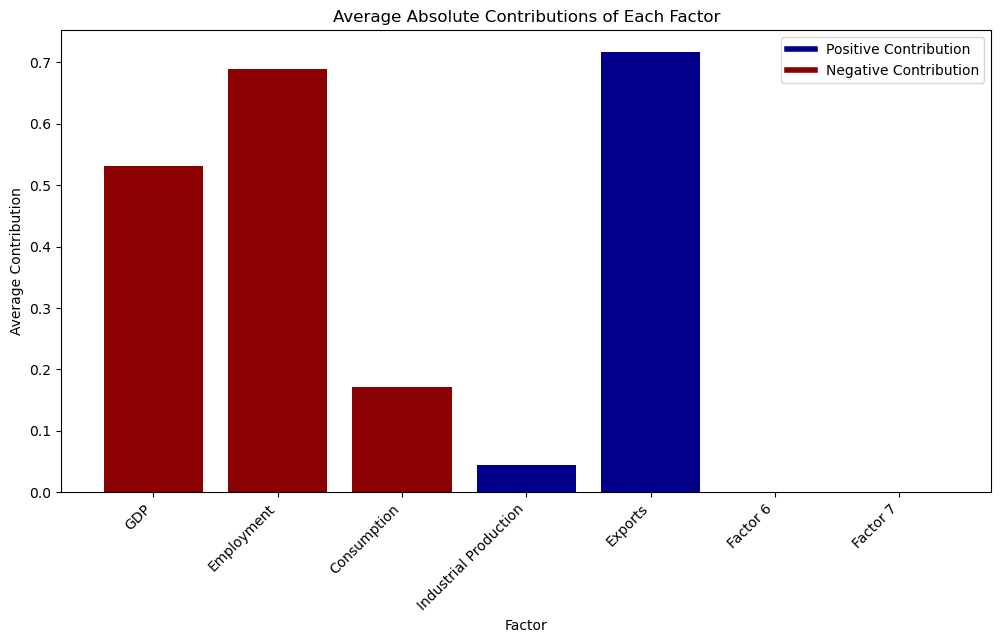

Factor 1 loadings:
 [[0.866]
 [0.866]]
Factor 2 loadings:
 [[-0.742]
 [-0.742]]
Factor 3 loadings:
 [[-0.923]
 [-0.923]]


AttributeError: 'DynamicFactorModel' object has no attribute 'F0'

In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

### Helper Functions

def _InterpolateNaN(Tseries):
    ## Interpolates NaN values
    not_nan, indices = np.logical_not(np.isnan(Tseries)), np.arange(len(Tseries)).reshape(-1,1)
    Tseries_fill = np.interp(indices, indices[not_nan], Tseries[not_nan]) 
    return Tseries_fill

def _NormDframe(df):
    # normalize each column of a dataframe 
    df2 = df.copy()
    df2 = (df2 - df2.mean())/df2.std()
    return df2

def _PCA_fact_load(data):
    pca = PCA(n_components=1)
    factor = pca.fit_transform(data)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    return factor, loadings

def _MakeLags(mat, lags):
    cols = mat.shape[1]
    Matlag = np.zeros((len(mat)-lags,cols*lags))
    for ii in range(lags, 0, -1):
        Matlag[:,0+cols*(lags-ii):cols*(lags-ii+1)] = mat[ii-1:(len(mat)-lags+ii-1),:];
    mat2 = mat.copy()
    mat2 = mat2[lags:,:]
    return mat2, Matlag 

def _estVAR(Yinput,lags):
    Y, X = _MakeLags(Yinput, lags)
    N = Y.shape[0]
    X = np.c_[X, np.ones((X.shape[0],1))]
    B = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    e = Y - (X @ B)
    Q = np.divide((e.T @ e),(N-lags))
    return B, Q

def _setVARpriors(X,Y,lambda1, lambda3, lambda4, p, alpha0):
    n = Y.shape[1]
    T = X.shape[0]
    k = X.shape[1] # includes all additional dummies
    m = k-n*p
    q=n*k; # coefficients to estimate in total 
    # Get variance estimate for each endogenous VAR
    arvar = np.empty((n,1))
    arvar[:] = np.nan
    ar = np.empty((n,1))
    ar[:] = np.nan
    for ii in range(0,n,1):
        # initiate the data
        Ytemp=Y[:,ii];
        Xtemp=X[:,ii:n*p:n]; # Get heterogenous constants in too
        # obtain the OLS estimator
        B= np.linalg.inv(Xtemp.T @ Xtemp) @ (Xtemp.T @ Ytemp)
        ar[ii] = B[0] # 1st AR term for each equation
        # obtain the vector of residuals
        eps=Ytemp - (Xtemp @ B)
        # obtain the variance of the series;
        arvar[ii]=np.divide((eps.T @ eps),(T-p))

    beta0=np.zeros((q,1));
    for ii in range(0,n,1):
        beta0[(ii)*k+ii]=ar[ii]
    
    # variance cov of prior on beta
    phi0=np.zeros((k,k))
    
    # set the variance for coefficients on lagged values
    for ii in range(0,n,1):
       for jj in range(0,p,1):
           phi0[(jj)*n+ii,(jj)*n+ii]=(1/arvar[ii])*((lambda1/((jj+1)**lambda3))**2)
       
    # need to add priors on the cross products!
    
    # exogenous variance
    if k>n*p:
        m = k-n*p
        for ii in range(0,m,1):
            phi0[k-m+ii,k-m+ii]=(lambda1*lambda4)^2      
    
    # variance priors

    S0=np.diag(arvar.flatten()); # Variance prior is with AR variance terms 
    return phi0, alpha0, S0, beta0

def _EstBVAR(Y,lags, phi0, alpha0, S0, beta0, draws):
    # Y = Data
    # Lags: Number of lags in BVAR
    # phi: variance on the priors of beta

    Y2, X = _MakeLags(Y, lags)
    T = X.shape[0] # time periods
    n = Y2.shape[1] # number of equations
    k = X.shape[1] # parameters in each equation
    
    B0=np.reshape(beta0,(k,n), order="F")
    invphi0=np.diag(1./np.diag(phi0))

    # compute phibar, defined in (1.4.16)
    invphibar=invphi0+(X.T @ X)
    C=np.linalg.cholesky(invphibar).T # Make upper triangular cholesky
    invC=np.linalg.inv(C)
    phibar=invC @ invC.T
    
    # Get ex post B matrix
    Bbar=phibar @ ((invphi0 @ B0) + (X.T @ Y2)) 
    
    # vectorise 
    betabar=Bbar.flatten().T
    
    # obtain alphabar, defined in (1.4.18)
    alphabar=T+alpha0
    
    # obtain ex post scale matrix S
    Sbar=(Y2.T @ Y2)+S0+(B0.T @ invphi0 @ B0)-(Bbar.T @ invphibar @ Bbar)

    # Initilize Gibbs draw
    sigma_gibbs = np.full((draws,n,n),np.nan) 
    beta_gibbs =np.full((draws,k,n),np.nan) 

    for ii in range(0,draws):
        # Draw Sigma
        C=np.linalg.cholesky(Sbar)
        
        # draw the matrix Z of alpha multivariate standard normal vectors
        Z = np.random.multivariate_normal(np.full(n,0), np.diag(np.full(n,1)), alphabar)
        # Adjust for var cov
        drawSig=(C @ np.linalg.inv(Z.T @ Z)) @ C.T
        sigma_gibbs[ii,:,:]=drawSig # store draw
        
        # Draw beta
        # compute the lower Choleski factor of sigma draw
        C=np.linalg.cholesky(drawSig)
        
        # compute the lower choleski factor of phi
        P=np.linalg.cholesky(phibar)
        
        # take a kn*1 random draw from a multivariate standard normal distribution, and redimension it to obtain a k*n matrix-variate normal
        w=np.random.normal(0, 1, k*n)
        # reshape to be shape of the beta mat
        W=np.reshape(w,(k,n))
        
        # obtain the random draw from the matrix-variate student by adding the location matrix and multiplying by both scale matrices
        drawBeta=Bbar+((P @ W) @ C.T)
        drawB = np.r_[drawBeta[0:,0:].T, np.c_[np.eye((n)*(lags-1)), np.zeros(((n)*(lags-1),(n)))]]

        #Check stability and redraw if necessary - break if not under stability limit
        count = 1
        while np.max(np.abs(np.linalg.eigvals(drawB)))>0.999:
            W = np.reshape(np.random.normal(0, 1, k*n),(k,n))
            drawBeta=Bbar+((P @ W) @ C.T)
            drawB = np.r_[drawBeta[0:,0:].T, np.c_[np.eye((n)*(lags-1)), np.zeros(((n)*(lags-1),(n)))]]
            count = count+1
            if count>10000:
                raise Exception('VAR not stationary!')
        
        beta_gibbs[ii,:,:]=drawBeta    
    return sigma_gibbs, beta_gibbs

def _Kfilter(Y, F, H, Q, R, F0):
    # X_t = F*X_t-1 + Eps_Q - Eps_Q*Eps_Q = Q - var-cov matrix of factors
    # Y_t = H*X_t + Eps_R - Eps_R*Eps_R = R - var-cov of factor loadings
    # Allows for missing data by setting missing data to F*X - so no news to factor from missing data
    # Returns states (S), and variance around estimate of states (P)
    n=Y.shape[1] # %size of coefs on factors for obs eqn
    k=F0.shape[1] #% vector of state
    T = Y.shape[0]
    P = np.full((T,k**2),np.nan) 
    S = np.full((T,k),np.nan) 
    Sp = F0[0,:] 
    Pp=np.eye(k)
    
    for i in range(0,T,1):
        y = Y[i,:].T.copy() # get row i of observed data
        
        # (Jagged edge) set data to prediction if NaN - no new news for kfilter
        if np.isnan(y).any():
            replace = H @ Sp # create fitted values of all 
            y[np.where(np.isnan(y))] = replace[np.where(np.isnan(y))] # replace just those with nan

        # updating eqns       
        nu = y - (H @ Sp)   # Error based on observab;es
        f = ((H @ Pp) @ H.T) + R
        finv=np.linalg.inv(f)
        
        Stt = Sp + (Pp @ H.T) @ (finv @ nu) # update eqn Kalman gain
        Ptt = Pp - ((Pp @ H.T) @ (finv @ H) @ Pp) # update eqn
        
        if i < T:
            Sp = F @ Stt
            Pp = ((F @ Ptt) @ F.T) + Q # projections before data update
        
        S[i,:] = Stt.T
        P[i,:] = np.reshape(Ptt,(k**2))
        
    return S, P

def _Ksmoother(F, H, Q, R, S, P, lags, n):
    # F: Transition matrix
    # H: Observation loadings
    # Q: Transition variance
    # R: Observation variance
    # S: Kalman filtered states
    T = S.shape[0]
    k = n*lags
    Qstar=Q[0:n,0:n]
    Fstar=F[0:n,:]
    Pdraw = np.full((T,k**2),np.nan) 
    Sdraw = np.full((T,k),np.nan)
    for ii in range(T-1,-1,-1):
        Sf = S[ii,0:n].T
        Stt = S[ii-1,:]
        Ptt = np.reshape(P[ii-1,:],(k,k))
        f = (Fstar @ Ptt @ Fstar.T) + Qstar
        finv = np.linalg.inv(f);
        nu = Sf - (Fstar @ Stt)
        
        Smean = Stt + (Ptt @ Fstar.T  @ finv @ nu)
        Svar = Ptt - (Ptt @ Fstar.T @ finv @ Fstar @ Ptt)
       
        Sdraw[ii,:] = Smean.T
        Pdraw[ii,:] = np.reshape(Svar,(k**2))           
    
    return Sdraw, Pdraw, Svar

def _RemoveOutliers(Data, SDs, Qs):
    for col in range(0,Data.shape[1]):
        Data[(Data[:,col] - np.nanmean(Data[:,col])) > SDs * np.nanstd(Data[:,col]), col] =  np.nanmean(Data[:,col])+SDs * np.nanstd(Data[:,col])
        Data[(Data[:,col] - np.nanmean(Data[:,col])) < -(SDs * np.nanstd(Data[:,col])), col] =  np.nanmean(Data[:,col])-SDs * np.nanstd(Data[:,col])
    return Data

def _SampleFactorsSimple(S,Svar, K, Qs):
    keep = np.setdiff1d(np.arange(0,S.shape[1]), np.arange(0,S.shape[1],(K+Qs))) # miss first so dont sample Quarterly
    Sdraw = S.copy()
    for ii in range(S.shape[0]):
        Sdraw[ii,keep] = np.random.multivariate_normal(S[ii,keep].T, np.diag(np.diag(Svar)[keep]), 1)
    return Sdraw

def _SampleLoadingsLags(S, XY, s0, alpha0, L_var_prior, lags, interv, Qs, K, lagsH):
    # S: Estimated factors, including lags
    # s0: Scale param for R
    # alpha0: deg of freedom param for R
    # b0: prior on loading coefficients
    # B0: prior variance on loading coefficients.
    # lags: number of lags of monthly data in DFM.
    # interv. Intervals of the data for each factor Y
    # Qs: Number of quarterly observable GDP series
    # Monthly_dat: matrix of all monthly data
    K = int(S.shape[1]/lags-Qs)
    T = XY.shape[0]
    N = XY.shape[1]
    # Get rid of nan
    XYnan = XY[~np.isnan(XY[:,Qs:]).any(axis=1)].copy()
    Beta = []
    cumsum = 0
    for ii in range(0,len(interv)):
        Beta.append( np.linalg.inv(S[0:XYnan.shape[0],Qs+ii:Qs+ii+(lagsH-1)*(Qs+K)+1:Qs+K].T @ S[0:XYnan.shape[0],Qs+ii:Qs+ii+(lagsH-1)*(Qs+K)+1:Qs+K]) @ (S[0:XYnan.shape[0],Qs+ii:Qs+ii+(lagsH-1)*(Qs+K)+1:Qs+K].T @ XYnan[:,Qs+cumsum:Qs+cumsum+interv[ii]]))
        cumsum = cumsum+Beta[ii-Qs].shape[1]

    Lf = np.zeros((N-Qs,K*lagsH+Qs*lagsH))
    # Add beta loading for each lag - add zeros for loading onto quarterly series
    for jj in range(0,lagsH):
        cumsize = 0
        for ii in range(len(interv)+Qs): # Make matrix of factor loadings for each factor
            if ii==0 or ii+1 % (K+Qs)==0:
                Lf[:,ii:ii+1] = np.zeros((N-Qs,1))
            else:
                Lf[cumsize:cumsize+Beta[ii-Qs].shape[1],jj*(K+Qs)+ii] = Beta[ii-Qs][jj,:].reshape(-1,1).T # Beta val on current factor
                # -phi*beta on lagged factor, and also b(2) if the data loads on to multiple factor lags
                cumsize = cumsize+Beta[ii-Qs].shape[1] 

    # Make loading matrix for observations including quarterly data
    Lf_con = np.c_[np.tile(np.c_[1/3, np.zeros((1,K))],(1,3)), np.tile(np.zeros((1,K+Qs)),(1,lags-3))]
    Lf = np.r_[Lf_con, np.c_[Lf, np.zeros((N-Qs,(lags-lagsH)*(K+Qs)))]]
    # Make bayesian draws of variance matrix for factor loading using 
    StoreE = np.empty([XY.shape[0],XY.shape[1]]) 
    R = np.zeros((XY.shape[1],XY.shape[1]))
    for n in range(0,XY.shape[1]):
        ed=XY[:,n] - S[:,:] @ Lf[n,:].T
        StoreE[:,n] = ed
        ed = ed[~np.isnan(ed)]
        # draw R(n,n)
        if n==0:
            s0=0.01
        else:
            s0=5
        R_bar = s0 +(ed.T @ ed)+Lf[n,:] @ np.linalg.inv(L_var_prior+np.linalg.inv(S.T @ S)) @ Lf[n,:].T # Assuming prior of zero, so no L          
        Rd = np.random.normal(0,1,T+alpha0)
        Rd = Rd.T @ Rd
        Rd = np.divide(R_bar,Rd)
        R[n,n]=Rd
    H = Lf
    return H, R, StoreE

def _SampleLoadingsLagsPhi(S, XY, s0, alpha0, L_var_prior, lags, interv, Qs, K, lagsH, Phi):
    # S: Estimated factors, including lags
    # s0: Scale param for R
    # alpha0: deg of freedom param for R
    # b0: prior on loading coefficients
    # B0: prior variance on loading coefficients.
    # lags: number of lags of monthly data in DFM.
    # interv. Intervals of the data for each factor Y
    # Qs: Number of quarterly observable GDP series
    # Monthly_dat: matrix of all monthly data
    K = int(S.shape[1]/lags-Qs)
    T = XY.shape[0]
    N = XY.shape[1]

    # Gen Quasi-differenced data
    Y_phi = _quasidiff(XY,Phi, Qs)
    Beta = []
    cumsum = 0
    # Get relevant factor for each observable and quasi difference the factor by the relevant phi, then store the estimated beta with the same block
    cumsize = 0
    for ii in range(0,len(interv)):
        Betatemp = np.zeros((lagsH,interv[ii]))
        for jj in range(0,interv[ii]):
            # Each lag uses the same quasidiff so it is tiled lagsH times
            notnan = ~np.isnan(Y_phi[:,Qs:]).any(axis=1)
            Sreg = _quasidiff(S[notnan,Qs+ii:Qs+ii+(lagsH)*(Qs+K):Qs+K],np.tile(Phi[cumsize+jj,:],(lagsH,1)),0)
            notnan[0] = False # exclude first obs given that S has been quasi differenced 
            Best = np.linalg.inv(Sreg.T @ Sreg) @ (Sreg.T @ Y_phi[notnan,Qs+cumsum+jj:Qs+cumsum+jj+1])
            Betatemp[:,jj] = Best.reshape((1,-1))
        Beta.append(Betatemp)
        cumsize = cumsize+interv[ii]
            
    Lf = np.zeros((N-Qs,K*(lagsH+1)+Qs*(lagsH+1))) # Need one extra factor above lagsH because of MA term
    Lfraw = np.zeros((N-Qs,K*(lagsH)+Qs*(lagsH))) # Loading matrix without phi - used to generate errors with which to sample phi 
    # Add beta loading for each lag - add zeros for loading onto quarterly series (since there is no MA term here)
    for jj in range(0,lagsH):
        cumsize = 0
        for ii in range(K+Qs): # Make matrix of factor loadings for each factor
            if ii==0 or ii+1 % (K+Qs)==0:
                Lf[:,ii:ii+1] = np.zeros((N-Qs,1))
            else:
                # Add beta to existing entry (may already be a -phi*beta in that location)
                Lf[cumsize:cumsize+Beta[ii-Qs].shape[1],jj*(K+Qs)+ii] = Lf[cumsize:cumsize+Beta[ii-Qs].shape[1],jj*(K+Qs)+ii]+Beta[ii-Qs][jj,:].reshape(-1,1).T
                Lfraw[cumsize:cumsize+Beta[ii-Qs].shape[1],jj*(K+Qs)+ii] = Beta[ii-Qs][jj,:].reshape(-1,1).T
                Lf[cumsize:cumsize+Beta[ii-Qs].shape[1],(jj+1)*(K+Qs)+ii] = (-Phi[cumsize:cumsize+Beta[ii-Qs].shape[1],:].T)*Beta[ii-Qs][jj,:].reshape(1,-1)
                cumsize = cumsize+Beta[ii-Qs].shape[1] 

    # Make loading matrix for observations including quarterly data
    Lf_con = np.c_[np.tile(np.c_[1/3, np.zeros((1,K))],(1,3)), np.tile(np.zeros((1,K+Qs)),(1,lags-3))]
    Lf = np.r_[Lf_con, np.c_[Lf, np.zeros((N-Qs,(lags-lagsH-1)*(K+Qs)))]] # -1 for MA term 
    Lfraw = np.r_[Lf_con, np.c_[Lfraw, np.zeros((N-Qs,(lags-lagsH)*(K+Qs)))]]
    # Make bayesian draws of variance matrix for factor loading using 
    StoreE = np.empty([Y_phi.shape[0],Y_phi.shape[1]]) 
    R = np.zeros((XY.shape[1],XY.shape[1]))
    for n in range(0,Y_phi.shape[1]):
        ed=Y_phi[:,n] - S[:,:] @ Lf[n,:].T
        edraw = XY[1:,n]-S[:,:] @ Lfraw[n,:].T
        StoreE[:,n] = edraw
        ed = ed[~np.isnan(ed)]
        # draw R(n,n)
        if n==0:
            s02=s0/10
        else:
            s02=s0*5
        R_bar = s02 +(ed.T @ ed)+Lf[n,:] @ np.linalg.inv(L_var_prior+np.linalg.inv(S.T @ S)) @ Lf[n,:].T # Assuming prior of zero, so no L          
        # for scale
        Rd = np.random.normal(0,1,T+alpha0)
        Rd = Rd.T @ Rd
        Rd = np.divide(R_bar,Rd)
        R[n,n]=Rd
    H = Lf
    return H, R, StoreE

def _SamplePhi(StoreE,R, Qs):
    Phi = np.zeros((StoreE.shape[1]-Qs,1))
    for ii in range(Qs,StoreE[:,Qs:].shape[1]):
        eps = StoreE[~np.isnan(StoreE[:,ii]),ii].reshape(-1,1)
        Eps, EpsL = _MakeLags(eps, 1)
        Phi[ii-1,0] = np.linalg.inv(EpsL.T @ EpsL) @ (EpsL.T @ Eps)
    return Phi 

def _quasidiff(Y,Phi,Skip):
    Yphi = Y[1:,Skip:]-Y[0:-1,Skip:] * Phi.T
    if Skip>0:
        Yphi = np.c_[Y[1:,0:Skip],Yphi]
    return Yphi

def initializevals(GDP, Monthly, lags, lagsH, K, Qs):
    # Initial values for model as follows
    # X_t = F*X_t-1 + Eps_Q - Eps_Q*Eps_Q = Q - var-cov matrix of factors
    # Y_t = H*X_t + Eps_R - Eps_R*Eps_R = R - var-cov of factor loadings
    
    # Initialize GDP data
    GDPnan = np.asarray(np.kron(GDP, [[np.nan], [np.nan], [1]])) # missing values for months not at end of quarter
    GDP_fill = _InterpolateNaN(GDPnan)
    cutoff = len(GDP_fill)

    # Standardize input data
    MonthlyDat_norm = []
    for df in Monthly:
        MonthlyDat_norm.append(_NormDframe(df[0:cutoff]))

    loadings = [None]*len(Monthly)
    Factors = [None]*len(Monthly)
    # Get principal components
    for df,num in zip(MonthlyDat_norm, range(len(MonthlyDat_norm))):
        Factors[num], loadings[num] = _PCA_fact_load(df[0:cutoff].fillna(method='ffill'))

    ## Make initial guess for factor loading matrix and factors
    F0 = np.concatenate(Factors,1) # Make matrix of each list entry
    N = len(np.concatenate(loadings,0)) # total number of observable monthly series
    Lf = np.zeros((N,len(loadings))) # Lf initial value for H
    cumsize = 0
    for ii in range(len(loadings)): # Make matrix of factor loadings for each factor
        Lf[cumsize:cumsize+len(loadings[ii]),ii] = loadings[ii].reshape(-1,1).T
        cumsize = cumsize+len(loadings[ii])

    # Make lag matrix of factor initialization, including interpolated monthly GDP
    F0 = np.hstack((GDP_fill, F0))
    F0_cut, F0lag = _MakeLags(F0, lags)

    # Make loading matrix for observations
    Lf_con = np.c_[np.tile(np.c_[1/3, np.zeros((1,K))],(1,3)), np.tile(np.zeros((1,K+Qs)),(1,lags-3))]
    H = np.r_[Lf_con, np.c_[np.zeros((N,1)), Lf, np.zeros((N,(lags-1)*(K+1)))]]    

    Monthly_dat = np.concatenate(MonthlyDat_norm,axis=1) # create single matrix of monthly data      
    ###### Obtain R, variance on observation matrix for initial guess:
    e = np.c_[GDP_fill[lags:,0:], Monthly_dat[lags:,0:]] - F0lag[:,] @ H.T
    e = e[~np.isnan(e).any(axis=1)] # Remove missing data rows
    R=np.divide((e.T @ e),(Monthly_dat.shape[0]-lags))
    # Initialize R, the variance matrix of observation equation residuals
    R = np.diag(np.diag(R))
    #
    ### Get VAR initial params and variances 
    #
    #% Run a VAR in F, obtain initial B and Q
    B, Q = _estVAR(F0_cut,lags)
    Q=np.c_[Q, np.zeros((K+1,(K+1)*(lags-1)))] # adapt to kalman formats
    Q = np.r_[Q, np.zeros(((K+1)*(lags-1),(K+1)*(lags)))] 
    F=np.r_[B[0:-1,0:].T, np.c_[np.eye((K+Qs)*(lags-1)), np.zeros(((K+Qs)*(lags-1),(K+Qs)))]]

    # Data for factor estimation - GDP every 3 months and monthly normalized data series
    XY = np.c_[GDPnan, Monthly_dat]
    S, P  = _Kfilter(XY, F, H, Q, R, F0lag)
    
    ints = [listel.shape[0] for listel in loadings] # loading restrictions - which observable loads onto which number on each factor

    return XY, H, R, F, Q, S, ints

def Gibbs_loop(XY,F, H, Q, R, S, lags, lagsH, K, Qs, s0, alpha0, L_var_prior, Ints, burn, save, GDPnorm):
    # XY: Monthly data
    # F: State transition initial
    # H: Loadings initial mat
    # Q: State transition variance term
    # R: Loading variance term
    # S: States initial
    # lags: number of lags in transition matrix
    # n: length of monthly
    # K: monthly factors
    # Qs: quarterly factors
    # s0: prior on factor loading variance
    # alpha0: scale param on factor loading variance:
    # L_var_prior: tightness on coefficient in factor loading (zero is prior)
    # Ints: Restrictions for loading on factors - number that load onto each
    # GDPnorm: Normalize GDP?
    # Create matrices to store results
    
    Hdraw = np.empty([H.shape[0],Q.shape[1],save]) 
    Qdraw = np.empty([Q.shape[0],Q.shape[1],save]) 
    Fdraw = np.empty([F.shape[0],F.shape[1],save])
    Pdraw = np.empty([S.shape[0],S.shape[1]*S.shape[1],save])
    Rdraw = np.empty([R.shape[0],R.shape[1],save])
    Sdraw = np.empty([S.shape[0],S.shape[1],save])

    iter = burn+save
    n = K+Qs

    #Initilize priors for state transition 
    lambda1 = 0.5
    lambda3 = 1
    lambda4 = 1000
    n = (K+Qs)
    alpha0=1
    S_Y, S_X = _MakeLags(S[:,0:K+Qs], lags)
    phi0, alpha0, S0, beta0 = _setVARpriors(S_X,S_Y,lambda1, lambda3, lambda4, lags, alpha0)
    keep = np.setdiff1d(np.arange(0,S.shape[1]), np.arange(0,S.shape[1],n))
    for ii in range(iter):
        if ii % 10==0:
            print('Completed ', str(ii/iter*100), "% of the loop")
        S, P  = _Kfilter(XY, F, H, Q, R, S)
        S, P, Svar = _Ksmoother(F, H, Q, R, S, P, lags, n)
        # Resample S with random shocks
        #S = _SampleFactors(XY, F, H, Q, R, S, P, lags, n)
        S = _SampleFactorsSimple(S,Svar, K, Qs)

        #Normalize states (except GDP)
        if GDPnorm:
            S[:,:] = (S[:,:]-np.mean(S[:,:], axis=0))/np.std(S[:,:],axis=0)
        else:
            S[:,keep] = (S[:,keep]-np.mean(S[:,keep], axis=0))/np.std(S[:,keep],axis=0)

        draws = 1
        sigma_gibbs, beta_gibbs = _EstBVAR(S[:,0:K+Qs],lags, phi0, alpha0, S0, beta0, draws)
        sigma = sigma_gibbs.reshape((sigma_gibbs.shape[1],sigma_gibbs.shape[2]))
        beta = beta_gibbs.reshape((beta_gibbs.shape[1],beta_gibbs.shape[2]))
        # Update Variance and State transition matrices
        Q = np.c_[sigma, np.zeros((K+1,(K+1)*(lags-1)))] # adapt to kalman formats
        Q = np.r_[Q, np.zeros(((K+1)*(lags-1),(K+1)*(lags)))] 
        F=np.r_[beta[0:,0:].T, np.c_[np.eye((K+Qs)*(lags-1)), np.zeros(((K+Qs)*(lags-1),(K+Qs)))]]
        
        # Make intervals for factor loadings so its clear which loads onto which
        H, R, StoreE = _SampleLoadingsLags(S, XY, s0, alpha0, L_var_prior, lags, Ints, Qs, K, lagsH)

        if ii >= burn:
            Hdraw[:,:,ii-burn] = H.copy()
            Qdraw[:,:,ii-burn] = Q.copy()
            Fdraw[:,:,ii-burn] = F.copy()
            Pdraw[:,:,ii-burn] = P.copy()
            Rdraw[:,:,ii-burn] = R.copy()
            Sdraw[:,:,ii-burn] = S.copy()
                
    return Hdraw, Qdraw, Fdraw, Pdraw, Rdraw, Sdraw 

def Gibbs_loopMA(XY,F, H, Q, R, S, lags, lagsH, K, Qs, s0, alpha0, L_var_prior, Ints, burn, save, GDPnorm):
    # XY: Monthly data
    # F: State transition initial
    # H: Loadings initial mat
    # Q: State transition variance term
    # R: Loading variance term
    # S: States initial
    # lags: number of lags in transition matrix
    # n: length of monthly
    # K: monthly factors
    # Qs: quarterly factors
    # s0: prior on factor loading variance
    # alpha0: scale param on factor loading variance:
    # L_var_prior: tightness on coefficient in factor loading (zero is prior)
    # Ints: Restrictions for loading on factors - number that load onto each
    # GDPnorm: normalize GDP factor?

    # Create matrices to store results
    Hdraw = np.empty([H.shape[0],Q.shape[1],save]) 
    Qdraw = np.empty([Q.shape[0],Q.shape[1],save]) 
    Fdraw = np.empty([F.shape[0],F.shape[1],save])
    Pdraw = np.empty([S.shape[0]-1,S.shape[1]*S.shape[1],save]) # reduced by one due to MA term
    Rdraw = np.empty([R.shape[0],R.shape[1],save])
    Sdraw = np.empty([S.shape[0]-1,S.shape[1],save]) # reduced by one due to MA term
    Phidraw = np.empty([XY.shape[1]-Qs,1,save]) # reduced by one due to MA term

    iter = burn+save
    n = K+Qs

    #Initilize priors for state transition 
    lambda1 = 0.5
    lambda3 = 1
    lambda4 = 1000
    n = (K+Qs)
    alpha0=1
    S_Y, S_X = _MakeLags(S[:,0:K+Qs], lags)
    phi0, alpha0, S0, beta0 = _setVARpriors(S_X,S_Y,lambda1, lambda3, lambda4, lags, alpha0)
    Phi = np.zeros((XY.shape[1]-Qs,1)) # Initialize MA coef at 0
    keep = np.setdiff1d(np.arange(0,S.shape[1]), np.arange(0,S.shape[1],n))
    for ii in range(iter):
        if ii % 10==0:
            print('Completed ', str(ii/iter*100), "% of the loop")

        XYquas = _quasidiff(XY,Phi, Qs)
        S, P  = _Kfilter(XYquas, F, H, Q, R, S)
        S, P, Svar = _Ksmoother(F, H, Q, R, S, P, lags, n)
        # Resample S with random shocks
        S = _SampleFactorsSimple(S,Svar, K, Qs)

        #Normalize states (except GDP if GDPnorm switched off)
        if GDPnorm:
            S[:,:] = (S[:,:]-np.mean(S[:,:], axis=0))/np.std(S[:,:],axis=0)
        else:
            S[:,keep] = (S[:,keep]-np.mean(S[:,keep], axis=0))/np.std(S[:,keep],axis=0)

        draws = 1
        sigma_gibbs, beta_gibbs = _EstBVAR(S[:,0:K+Qs],lags, phi0, alpha0, S0, beta0, draws)
        sigma = sigma_gibbs.reshape((sigma_gibbs.shape[1],sigma_gibbs.shape[2]))
        beta = beta_gibbs.reshape((beta_gibbs.shape[1],beta_gibbs.shape[2]))
        # Update Variance and State transition matrices
        Q = np.c_[sigma, np.zeros((K+1,(K+1)*(lags-1)))] # adapt to kalman formats
        Q = np.r_[Q, np.zeros(((K+1)*(lags-1),(K+1)*(lags)))] 
        F=np.r_[beta[0:,0:].T, np.c_[np.eye((K+Qs)*(lags-1)), np.zeros(((K+Qs)*(lags-1),(K+Qs)))]]
        
        # Make intervals for factor loadings so its clear which loads onto which
        H, R, StoreE = _SampleLoadingsLagsPhi(S, XY, s0, alpha0, L_var_prior, lags, Ints, Qs, K, lagsH, Phi)
        Phi = _SamplePhi(StoreE,R, Qs)

        if ii >= burn:
            Hdraw[:,:,ii-burn] = H.copy()
            Qdraw[:,:,ii-burn] = Q.copy()
            Fdraw[:,:,ii-burn] = F.copy()
            Pdraw[:,:,ii-burn] = P.copy()
            Rdraw[:,:,ii-burn] = R.copy()
            Sdraw[:,:,ii-burn] = S.copy()
            Phidraw[:,:,ii-burn] = Phi.copy()
                
    return Hdraw, Qdraw, Fdraw, Pdraw, Rdraw, Sdraw, Phidraw 





#############################################################################
#  Dynamic factor model class - includes initialization ,estimation, and nowcasting routines

class DynamicFactorModel():
    def __init__(self, Q_GDP, Monthly, Dates, K, Qs, lags, lagsH, MAterm, normGDP):
        self.GDP = Q_GDP
        self.Monthly = Monthly
        self.Dates = Dates
        self.K = K
        self.Qs = Qs
        self.lags = lags
        self.lagsH = lagsH
        self.MAterm = MAterm
        self.normGDP = normGDP
        
    def estimateGibbs(self, burn, save, s0 = 0.1, alpha0 = 1, L_var_prior = None):
        if L_var_prior is None:
            L_var_prior = np.identity((self.K+self.Qs)*self.lags)
        
        self.XY, H, R, F, Q, S, ints = initializevals(self.GDP, self.Monthly, self.lags, self.lagsH, self.K, self.Qs)
        
        if self.normGDP:
            self.GDPmean = np.nanmean(self.GDP)
            self.GDPstd = np.nanstd(self.GDP)
            self.XY[0:,0] = (self.XY[0:,0] - self.GDPmean)/self.GDPstd
        
        XYcomp = self.XY[0:self.GDP.shape[0]*3,:].copy()
        self.XYcomp = _RemoveOutliers(XYcomp, 4, 0)
        self.s0 = s0 # prior for var on loadings
        self.alpha0 = alpha0 # scale on var for loadings
        self.L_var_prior = L_var_prior # var on prior on loading betas (0 by default)

        if self.MAterm == 0:
            self.Hdraw, self.Qdraw, self.Fdraw, self.Pdraw, self.Rdraw, self.Sdraw  = Gibbs_loop(self.XYcomp,F, H, Q, R, S, self.lags, self.lagsH, self.K \
                , self.Qs, s0, alpha0, L_var_prior, ints, burn, save, self.normGDP)
            return self.Hdraw, self.Qdraw, self.Fdraw, self.Pdraw, self.Rdraw, self.Sdraw
        elif self.MAterm == 1:
            self.Hdraw, self.Qdraw, self.Fdraw, self.Pdraw, self.Rdraw, self.Sdraw, self.Phidraw  = Gibbs_loopMA(self.XYcomp,F, H, Q, R, S, self.lags, self.lagsH, self.K \
                , self.Qs, s0, alpha0, L_var_prior, ints, burn, save, self.normGDP)

    def Nowcast(self, start, Horz):
        XY = self.XY
        Dates = self.Dates
        Hdraw = self.Hdraw
        Qdraw = self.Qdraw
        Fdraw = self.Fdraw
        Rdraw = self.Rdraw
        Sdraw = self.Sdraw
        Qs = self.Qs
        K = self.K

        Hfor = np.median(Hdraw[:,:,:],axis=2)
        Qfor = np.median(Qdraw[:,:,:],axis=2)
        Ffor = np.median(Fdraw[:,:,:],axis=2)
        Rfor = np.median(Rdraw[:,:,:],axis=2)
        Sfor = np.median(Sdraw[:,:,:],axis=2)

        # Ensure that there are required number of Months of nans after final GDP reading
        Total = Dates.shape[0]*3+Horz*3
        if XY.shape[0]<Total:
            NewNans = np.empty((Total-XY.shape[0],XY.shape[1]))
            NewNans[:] = np.nan
            XYf = np.r_[XY, NewNans]

        if self.MAterm==1:
            Phidraw = self.Phidraw
            Phifor = np.median(Phidraw[:,:,:],axis=2)
            XYf = _quasidiff(XYf,Phifor,Qs)
        
        date_index = np.where(Dates == start)[0]
        if len(date_index) != 1:
            raise ValueError(f"Start date '{start}' not found or ambiguous in Dates.")
        Findex = int(date_index[0])
        
        Quartersback = (Dates.shape[0] - Findex)
        self.Quartersback = Quartersback
        
        Fcast_current = np.empty((Quartersback+1, 3)) # Store nowcast from each month for each quarter
        Fcast_next = np.empty((Quartersback+1, 3))
        Outturn_current = np.empty((Quartersback+1,3)) 
        Outturn_next = np.empty((Quartersback+1,3)) 
        DateFcast = np.arange(start, start + Quartersback/4, 0.25)
        for ii in range(Quartersback+1):
            if ii == Quartersback:
                newvar = 1
            PriorS = Sfor[-(Quartersback)*3-1+ii*3,:].reshape(1,-1)
            XYsnap = XYf[-(Quartersback+Horz)*3+ii*3:-(Quartersback+Horz)*3+(ii*3+3),:] # Slice of data
            for jj in range(3):
                Outturn_current[ii,jj] = XYsnap[2,0]
                if ii < Quartersback-1:
                    Outturn_next[ii,jj] = XYf[-(Quartersback+Horz)*3+(ii*3+5):-(Quartersback+Horz)*3+(ii*3+6),0]
                Feed = XYsnap.copy()
                if jj < 2:
                    Feed[-2+jj:,:] = np.nan
                Feed[2,0] = np.nan # ensure that the GDP figure is obscured.
                S_f, P_f  = _Kfilter(Feed, Ffor, Hfor, Qfor, Rfor, PriorS)
                Fcast_current[ii,jj] = np.mean(S_f[0:3,0])
                FeedNext = np.r_[Feed, np.nan*np.empty((3,Feed.shape[1]))]
                S_fn, P_fn  = _Kfilter(FeedNext, Ffor, Hfor, Qfor, Rfor, PriorS)
                Fcast_next[ii,jj] = np.mean(S_fn[3:,0])
        
        # Un-normalize if option has been used 
        if self.normGDP:
            Fcast_current = Fcast_current * self.GDPstd + self.GDPmean
            Fcast_next = Fcast_next * self.GDPstd + self.GDPmean
            Outturn_current = Outturn_current * self.GDPstd + self.GDPmean
            Outturn_next = Outturn_next * self.GDPstd + self.GDPmean

        # Calculate RMSEs
        RMSE = np.empty((3,2))
        for ii in range(3):
            CurrentErr = np.square(Fcast_current[:,ii] - Outturn_current[:,ii])
            NextErr = np.square(Fcast_next[:,ii] - Outturn_next[:,ii])
            RMSE[ii,:] = np.c_[np.sqrt(np.nanmean(CurrentErr)), np.sqrt(np.nanmean(NextErr))] 
        Datesaug = np.r_[Dates, Dates[-1:] + 0.25]

        self.Fcast_current = Fcast_current
        self.Fcast_next = Fcast_next
        self.Outturn_current = Outturn_current
        self.Outturn_next = Outturn_next
        self.RMSE = RMSE
        self.Datesaug = Datesaug

    def PlotFcast(self, Month):
        titlelist = ['Month 1', 'Month 2', 'Month 3']
        fig1 = plt.figure(figsize=(15, 15))
        ax1 = fig1.add_subplot(111)
        ax1.plot(self.Datesaug[-self.Quartersback-1:], self.Fcast_current[:, Month-1], marker='o', color='darkblue', linewidth=2)
        ax1.plot(self.Datesaug[-self.Quartersback-1:], self.Outturn_current[:, Month-1], marker='o', color='darkred', linewidth=2)
        ax1.legend(['Nowcast', 'Actual'])
        ax1.set_title(titlelist[Month-1])
        plt.show()

    def PlotContributions(self):
            Hdraw = self.Hdraw
            Fdraw = self.Fdraw
            Sdraw = self.Sdraw

            Hfor = np.median(Hdraw[:,:,:], axis=2)
            Ffor = np.median(Fdraw[:,:,:], axis=2)
            Sfor = np.median(Sdraw[:,:,:], axis=2)

            factors = np.dot(Sfor, Hfor.T)
            contributions = factors  # Use raw factors for signed contributions

            avg_contributions = np.mean(np.abs(contributions), axis=0)  # Average absolute contributions
            sign_contributions = np.sign(np.mean(contributions, axis=0))  # Determine sign of contributions

            # Define the variable names and assign them to factors based on the initial setup
            variables = ['GDP', 'Employment', 'Consumption', 'Industrial Production', 'Exports'] 

            # Ensure the list length matches avg_contributions
            factor_interpretations = variables + [f"Factor {i+len(variables)+1}" for i in range(len(avg_contributions) - len(variables))]

            # Verify the factor names and contributions alignment
            assert len(factor_interpretations) == len(avg_contributions), "Factor names and contributions are misaligned."

            fig, ax = plt.subplots(figsize=(12, 6))
            bars = ax.bar(range(len(avg_contributions)), avg_contributions, color=['darkblue' if sign > 0 else 'darkred' for sign in sign_contributions])
            ax.set_title('Average Absolute Contributions of Each Factor')
            ax.set_xlabel('Factor')
            ax.set_ylabel('Average Contribution')

            # Set x-axis labels to the factor names
            ax.set_xticks(range(len(avg_contributions)))
            ax.set_xticklabels(factor_interpretations, rotation=45, ha='right')

            
            # Add a legend to explain the colors
            from matplotlib.lines import Line2D
            legend_elements = [Line2D([0], [0], color='darkblue', lw=4, label='Positive Contribution'),
                               Line2D([0], [0], color='darkred', lw=4, label='Negative Contribution')]
            ax.legend(handles=legend_elements, loc='upper right')

            plt.show()


    def inspect_factor_loadings(self):
        # Inspect PCA factor loadings
        for i, monthly_data in enumerate(self.Monthly):
            _, loadings = _PCA_fact_load(_NormDframe(monthly_data))
            print(f"Factor {i+1} loadings:\n", loadings)

    def inspect_VAR_parameters(self):
        # Inspect initial VAR parameters
        F0_cut, _ = _MakeLags(self.F0, self.lags)
        B, Q = _estVAR(F0_cut, self.lags)
        print("Initial VAR B matrix:\n", B)
        print("Initial VAR Q matrix:\n", Q)


###########################################################################################
# Very simple data example of nowcasting US quarterly GDP using 3 factors (of only two series each) using FRED data.
# Most nowcasting programs will use PMIs and other proprierary series that cannot be posted publicaly
# This code will also work with 

excel_file = os.path.join(r'ImportFile.xlsx')

####################################################
# Import data
GDP_dat = pd.read_excel(excel_file, sheet_name='GDP')
Emp_dat = pd.read_excel(excel_file, sheet_name='Emp')
Cons_dat = pd.read_excel(excel_file, sheet_name='Cons')
IPExp_dat = pd.read_excel(excel_file, sheet_name='IPExp')

GDP = GDP_dat['GDP'][0:].values.reshape(-1,1) # GDP data for nowcasting
Dates = GDP_dat.Date

## Make list of pandas monthly frames
MonthlyDat = [Emp_dat.drop(columns=['Date']), 
                        Cons_dat.drop(columns='Date'), IPExp_dat.drop(columns='Date')]

MAterm = 0 # turn on or off the errors in the observation equations (Var-Cov R) taking an MA specification. (eps_r = rho*eps_e(t-1)+eps)
lags = 6 # state transition equation number of lags
lagsH = 1 # Number of lags to use in observation equation (of the factors)
K = 3 # number of non GDP factors, (entries in monthlydat)
Qs = 1 # number of GDP factors - Do not adjust number of GDP series - possibly this will be adapted in the future - only works with one for now.
normGDP = 1 # estimate model with a normalized GDP series
# Initialise the factor model
DynamicFac = DynamicFactorModel(GDP, MonthlyDat, Dates, K, Qs, lags, lagsH, MAterm, normGDP)

burn = 500
save = 1000
# Initialize and estimate the model
DynamicFac.estimateGibbs(burn, save)

# Perform the nowcasting
DynamicFac.Nowcast(2008.0, 2)  # example: starting from 2008 for 2 quarters forward

# Plot the contributions
DynamicFac.PlotContributions()

# Inspect factor loadings
DynamicFac.inspect_factor_loadings()

# Inspect VAR parameters
DynamicFac.inspect_VAR_parameters()

print('Plot quasi-out of sample month 2 nowcasts against data (these use full estimation sample to estimate parameters and previous quarter state)')
DynamicFac.PlotFcast(2) # Plot forecast 

np.set_printoptions(precision=3)

print('View RMSEs, as current quarter, next quarter (columns), and months (1,2,3) of the quarter (rows).')
print(DynamicFac.RMSE)  
print('Series of current quarter nowcasts (quarters rows, columns month of each quarter)')
print(DynamicFac.Fcast_current) 
print('Series of next quarter nowcasts (quarters rows, columns month of each quarter)')
print(DynamicFac.Fcast_next)

print('GDP outturn')
print(DynamicFac.Outturn_current)

print('Dates series')
print(DynamicFac.Datesaug)


